# Khai báo thư viện

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import optuna
#------------------------------------------------------------------
from sklearn import preprocessing #has preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#------------------------------------------------------------------
from scipy.stats import uniform
from scipy.cluster.hierarchy import dendrogram, linkage
from tabulate import tabulate
#------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
#------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
import skfuzzy as fuzz
#------------------------------------------------------------------
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import make_scorer
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
# ------------------------------------------------------------------
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from joblib import Parallel, delayed
import optuna
from optuna.pruners import MedianPruner

# Data

In [53]:
df = pd.read_csv("C:/Users/Hali/Documents/Python/Mall_Customers_preprocessed.csv")
X = df.drop(columns=["customerid"])

In [54]:
data = df.drop(columns=["customerid",],axis=1,)
X = data.copy()

In [55]:
print(f"Mall_Customers_preprocessed")
print(tabulate(X.head(), headers='keys', tablefmt='grid'))

Mall_Customers_preprocessed
+----+-----------+-----------------+------------------+----------------+
|    |       age |   annual_income |   spending_score |   genre_Female |
+====+===========+=================+==================+================+
|  0 | -1.42457  |        -1.739   |        -0.434801 |              0 |
+----+-----------+-----------------+------------------+----------------+
|  1 | -1.28104  |        -1.739   |         1.1957   |              0 |
+----+-----------+-----------------+------------------+----------------+
|  2 | -1.3528   |        -1.70083 |        -1.71591  |              1 |
+----+-----------+-----------------+------------------+----------------+
|  3 | -1.1375   |        -1.70083 |         1.04042  |              1 |
+----+-----------+-----------------+------------------+----------------+
|  4 | -0.563369 |        -1.66266 |        -0.39598  |              1 |
+----+-----------+-----------------+------------------+----------------+


# Fuzzy C-Means

In [56]:
#Thực hiện Fuzzy C-Means
data = X.values.T  # FCM yêu cầu dạng (features, samples)

In [57]:
fuzz_clusters = 6 #Số lượng cụm và các chỉ số khác đã được Optimize
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data, c=fuzz_clusters, m=1.5, error=0.005, maxiter=1000, init=None, seed=42)

In [58]:
labels = np.argmax(u, axis=0)
df["cluster_fcm"] = labels

In [59]:
silhouette_fuzz = silhouette_score(X, labels)
davies_bouldin_fuzz = davies_bouldin_score(X, labels)
calinski_harabasz_fuzz = calinski_harabasz_score(X, labels)

In [60]:
print(f"Fuzzy C-Means:")
print(f"- Số lượng cụm: {fuzz_clusters}")
print(f"- Silhouette Score: {silhouette_fuzz:.3f}")
print(f"- Davies Bouldin: {davies_bouldin_fuzz:.3f}")
print(f"- Calinski Harabaz: {calinski_harabasz_fuzz:.3f}")

Fuzzy C-Means:
- Số lượng cụm: 6
- Silhouette Score: 0.357
- Davies Bouldin: 1.010
- Calinski Harabaz: 99.446


In [61]:
#Giảm số chiều về 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

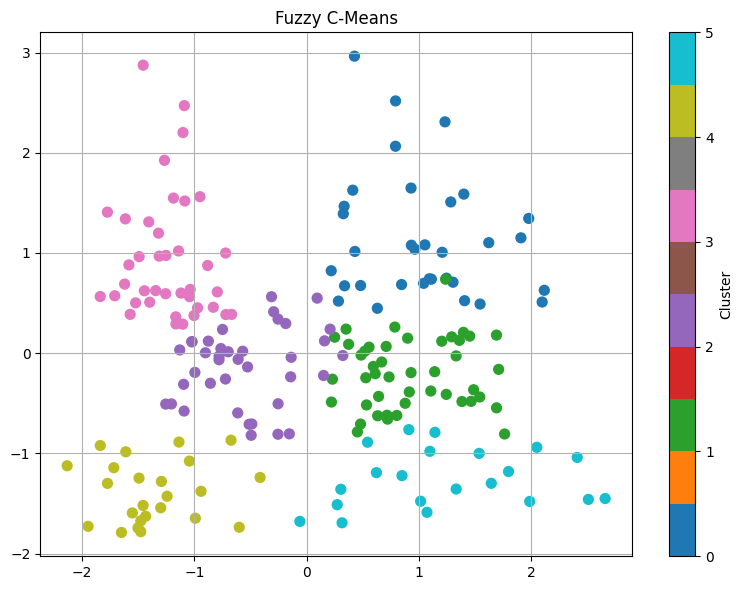

In [62]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=50)
plt.title("Fuzzy C-Means")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Affinity Propagation

In [63]:
#Thực hiện AP Default
ap = AffinityPropagation()
ap_labels = ap.fit_predict(X)

In [64]:
n_clusters_ap = len(np.unique(ap_labels))
silhouette_ap = silhouette_score(X, ap_labels)
davies_bouldin_ap = davies_bouldin_score(X, ap_labels)
calinski_harabasz_ap = calinski_harabasz_score(X, ap_labels)

In [65]:
print(f"Affinity Propagation Default:")
print(f"- Số lượng cụm: {n_clusters_ap}")
print(f"- Silhouette Score: {silhouette_ap:.3f}")
print(f"- Davies Bouldin: {davies_bouldin_ap:.3f}")
print(f"- Calinski Harabaz: {calinski_harabasz_ap:.3f}")

Affinity Propagation Default:
- Số lượng cụm: 17
- Silhouette Score: 0.340
- Davies Bouldin: 1.025
- Calinski Harabaz: 80.077


In [66]:
#Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)
labels = ap.labels_
exemplars = ap.cluster_centers_indices_

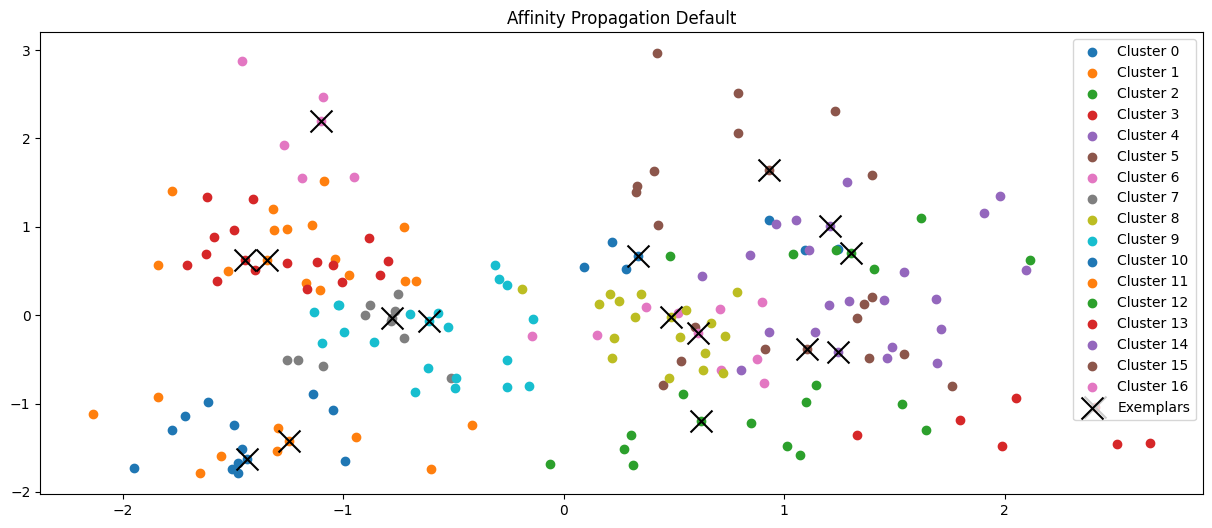

In [67]:
plt.figure(figsize=(15, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("Affinity Propagation Default")
plt.show()

In [68]:
#AP Random Search Optimization
ap = AffinityPropagation(random_state=42, damping=0.560, preference=-64.450)
ap_labels = ap.fit_predict(X)

In [69]:
n_clusters_rs = len(np.unique(ap_labels))
silhouette_rs = silhouette_score(X, ap_labels)
davies_bouldin_rs = davies_bouldin_score(X, ap_labels)
calinski_harabasz_rs = calinski_harabasz_score(X, ap_labels)

In [70]:
print(f"Random Search Optimization:")
print(f"- Số lượng cụm: {n_clusters_rs}")
print(f"- Silhouette Score: {silhouette_rs:.3f}")
print(f"- Davies Bouldin: {davies_bouldin_rs:.3f}")
print(f"- Calinski Harabaz: {calinski_harabasz_rs:.3f}")

Random Search Optimization:
- Số lượng cụm: 4
- Silhouette Score: 0.345
- Davies Bouldin: 1.083
- Calinski Harabaz: 99.483


In [71]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

In [72]:
labels = ap.labels_
exemplars = ap.cluster_centers_indices_

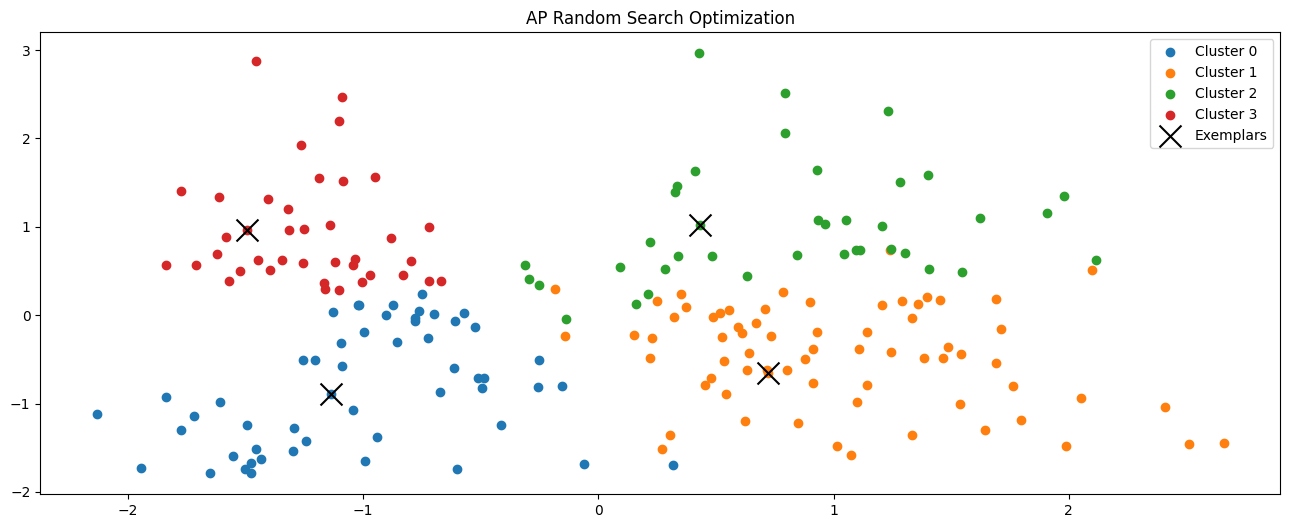

In [73]:
plt.figure(figsize=(16, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("AP Random Search Optimization")
plt.show()

In [74]:
#AP Bayesian Optimazation
ap = AffinityPropagation(random_state=42, damping=0.820, preference=-1.708)
ap_labels = ap.fit_predict(X)

In [75]:
n_clusters_b = len(np.unique(ap_labels))
silhouette_b = silhouette_score(X, ap_labels)
davies_bouldin_b = davies_bouldin_score(X, ap_labels)
calinski_harabasz_b = calinski_harabasz_score(X, ap_labels)

In [76]:
print(f"Bayesian Optimazation:")
print(f"- Số lượng cụm: {n_clusters_b}")
print(f"- Silhouette Score: {silhouette_b:.3f}")
print(f"- Davies Bouldin: {davies_bouldin_b:.3f}")
print(f"- Calinski Harabaz: {calinski_harabasz_b:.3f}")

Bayesian Optimazation:
- Số lượng cụm: 31
- Silhouette Score: 0.375
- Davies Bouldin: 0.827
- Calinski Harabaz: 78.943


In [77]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

In [78]:
labels = ap.labels_
exemplars = ap.cluster_centers_indices_

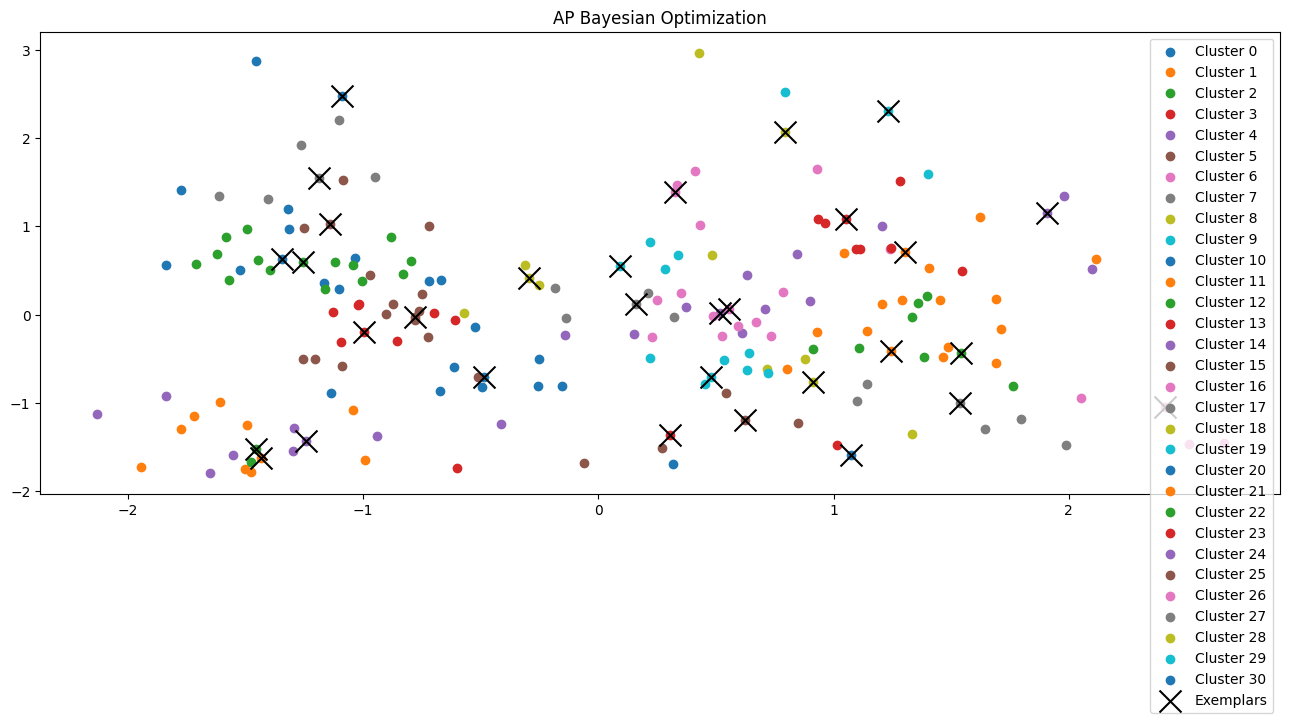

In [79]:
plt.figure(figsize=(16, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("AP Bayesian Optimization")
plt.show()

In [80]:
#AP Grid Search Optimization
ap = AffinityPropagation(random_state=42, damping=0.7, preference=-2.013)
ap_labels = ap.fit_predict(X)

In [81]:
n_clusters_gs = len(np.unique(ap_labels))
silhouette_gs = silhouette_score(X, ap_labels)
davies_bouldin_gs = davies_bouldin_score(X, ap_labels)
calinski_harabasz_gs = calinski_harabasz_score(X, ap_labels)

In [82]:
print(f"Grid Search Optimization:")
print(f"- Số lượng cụm: {n_clusters_gs}")
print(f"- Silhouette Score: {silhouette_gs:.3f}")
print(f"- Davies Bouldin: {davies_bouldin_gs:.3f}")
print(f"- Calinski Harabaz: {calinski_harabasz_gs:.3f}")

Grid Search Optimization:
- Số lượng cụm: 26
- Silhouette Score: 0.371
- Davies Bouldin: 0.882
- Calinski Harabaz: 76.514


In [83]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

In [84]:
labels = ap.labels_
exemplars = ap.cluster_centers_indices_

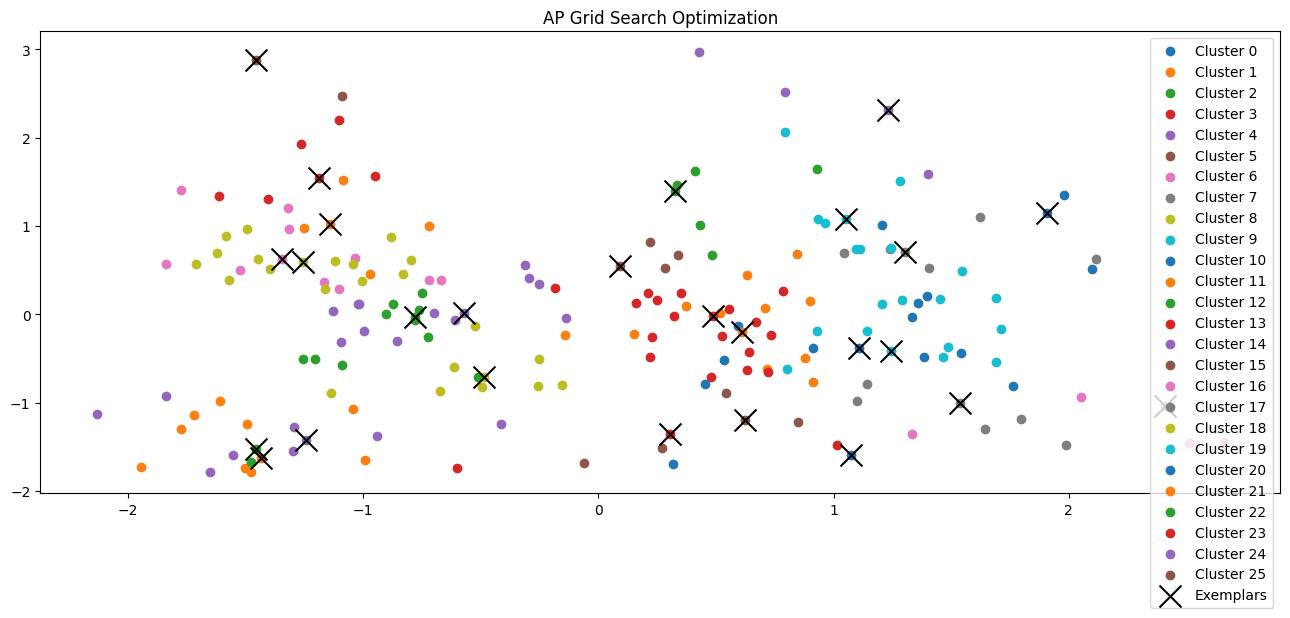

In [85]:
plt.figure(figsize=(16, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("AP Grid Search Optimization")
plt.show()

In [86]:
#AP Optuna Optimization
ap = AffinityPropagation(random_state=42, damping=0.6, preference=-74.497)
ap_labels = ap.fit_predict(X)

In [87]:
n_clusters_o = len(np.unique(ap_labels))
silhouette_o = silhouette_score(X, ap_labels)
davies_bouldin_o = davies_bouldin_score(X, ap_labels)
calinski_harabasz_o = calinski_harabasz_score(X, ap_labels)

In [88]:
print(f"Optuna Optimization:")
print(f"- Số lượng cụm: {n_clusters_o}")
print(f"- Silhouette Score: {silhouette_o:.3f}")
print(f"- Davies Bouldin: {davies_bouldin_o:.3f}")
print(f"- Calinski Harabaz: {calinski_harabasz_o:.3f}")

Optuna Optimization:
- Số lượng cụm: 4
- Silhouette Score: 0.327
- Davies Bouldin: 1.047
- Calinski Harabaz: 93.580


In [89]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

In [90]:
labels = ap.labels_
exemplars = ap.cluster_centers_indices_

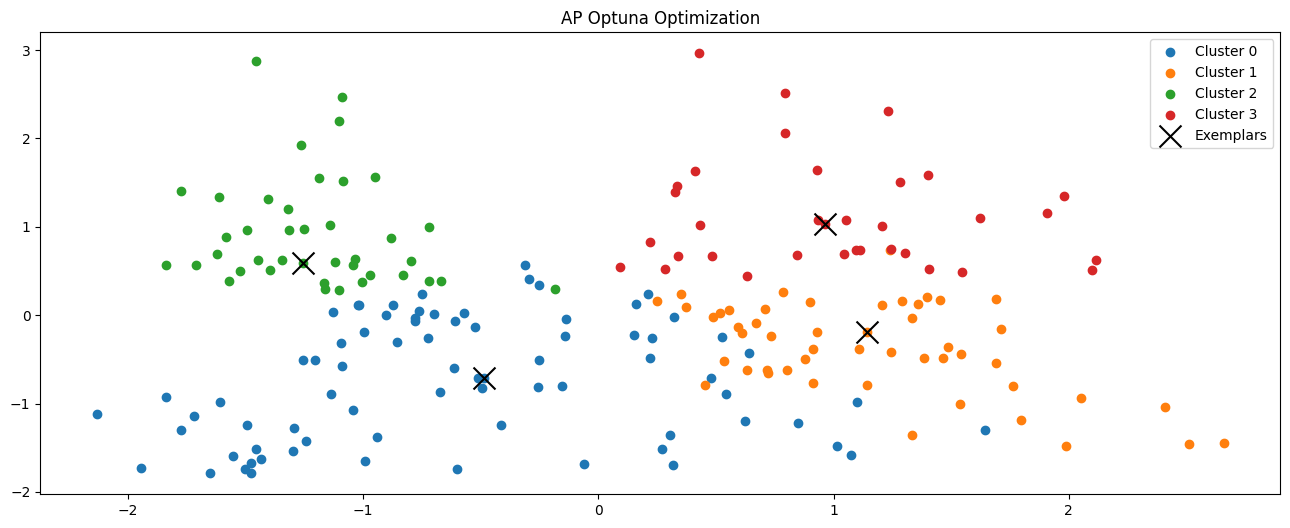

In [91]:
plt.figure(figsize=(16, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("AP Optuna Optimization")
plt.show()

In [92]:
#AP Hyperopt Optimization
ap = AffinityPropagation(random_state=42, damping=0.9, preference=-2.013)
ap_labels = ap.fit_predict(X)

In [93]:
n_clusters_h = len(np.unique(ap_labels))
silhouette_h = silhouette_score(X, ap_labels)
davies_bouldin_h = davies_bouldin_score(X, ap_labels)
calinski_harabasz_h = calinski_harabasz_score(X, ap_labels)

In [94]:
print(f"Hyperopt Optimization:")
print(f"- Số lượng cụm: {n_clusters_h}")
print(f"- Silhouette Score: {silhouette_h:.3f}")
print(f"- Davies Bouldin: {davies_bouldin_h:.3f}")
print(f"- Calinski Harabaz: {calinski_harabasz_h:.3f}")

Hyperopt Optimization:
- Số lượng cụm: 26
- Silhouette Score: 0.371
- Davies Bouldin: 0.882
- Calinski Harabaz: 76.514


In [95]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

In [96]:
labels = ap.labels_
exemplars = ap.cluster_centers_indices_

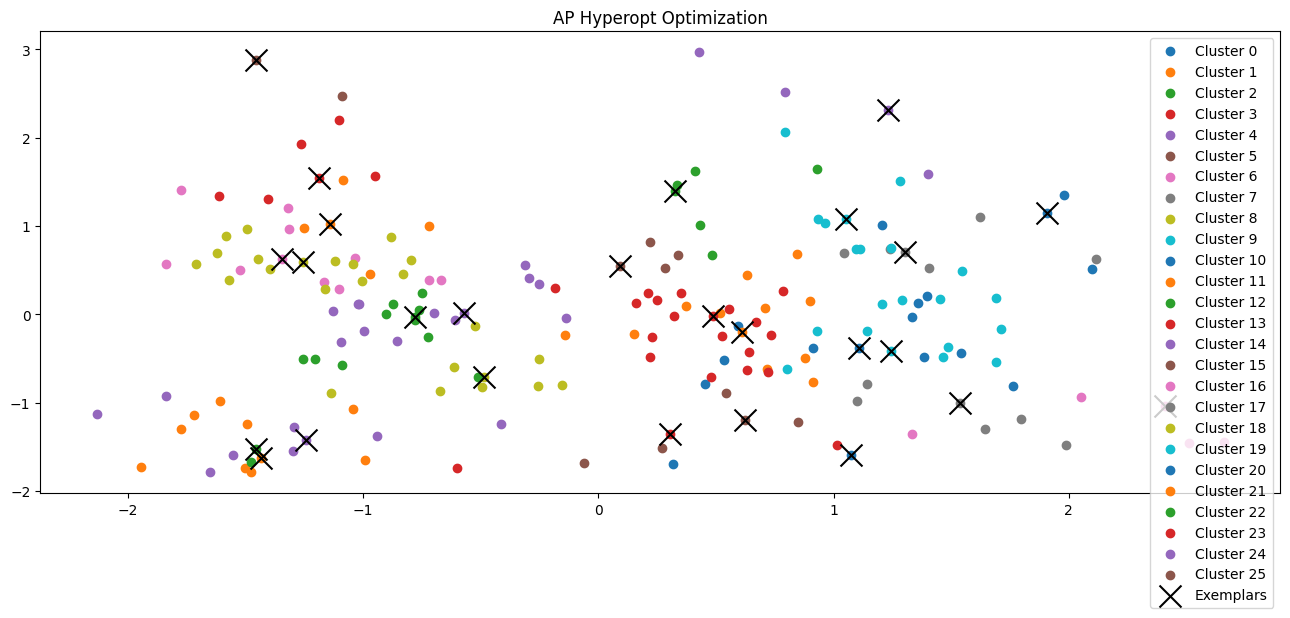

In [97]:
plt.figure(figsize=(16, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("AP Hyperopt Optimization")
plt.show()

In [98]:
# Bảng so sánh

In [99]:
#Bảng so sánh:
results = pd.DataFrame([
    {
        "Thuật toán": "AP Default",
        "Số cụm": n_clusters_ap,
        "Silhouette": round(silhouette_ap, 3),
        "Davies-Bouldin": round(davies_bouldin_ap, 3),
        "Calinski-Harabasz": round(calinski_harabasz_ap, 3)
    },
    {
        "Thuật toán": "AP Random Search Optimization",
        "Số cụm": n_clusters_rs,
        "Silhouette": round(silhouette_rs, 3),
        "Davies-Bouldin": round(davies_bouldin_rs, 3),
        "Calinski-Harabasz": round(calinski_harabasz_rs, 3)
    },
    { 
        "Thuật toán": "AP Bayesian Optimization",
        "Số cụm": n_clusters_b,
        "Silhouette": round(silhouette_b, 3),
        "Davies-Bouldin": round(davies_bouldin_b, 3),
        "Calinski-Harabasz": round(calinski_harabasz_b, 3)
    },
    {
        "Thuật toán": "AP Grid Search Optimization",
        "Số cụm": n_clusters_gs,
        "Silhouette": round(silhouette_gs, 3),
        "Davies-Bouldin": round(davies_bouldin_gs, 3),
        "Calinski-Harabasz": round(calinski_harabasz_gs, 3)
    },
    {
        "Thuật toán": "AP Optuna Optimization",
        "Số cụm": n_clusters_o,
        "Silhouette": round(silhouette_o, 3),
        "Davies-Bouldin": round(davies_bouldin_o, 3),
        "Calinski-Harabasz": round(calinski_harabasz_o, 3)
    },
    {
        "Thuật toán": "AP Hyperopt Optimization",
        "Số cụm": n_clusters_h,
        "Silhouette": round(silhouette_h, 3),
        "Davies-Bouldin": round(davies_bouldin_h, 3),
        "Calinski-Harabasz": round(calinski_harabasz_h, 3)
    },
    {
        "Thuật toán": "Fuzzy C-Means",
        "Số cụm": fuzz_clusters,
        "Silhouette": round(silhouette_fuzz, 3),
        "Davies-Bouldin": round(davies_bouldin_fuzz, 3),
        "Calinski-Harabasz": round(calinski_harabasz_fuzz, 3)
    }
])

In [100]:
# In bảng so sánh
print("\nBảng so sánh kết quả phân cụm:")
print(tabulate(results, headers='keys', tablefmt='grid')) 


Bảng so sánh kết quả phân cụm:
+----+-------------------------------+----------+--------------+------------------+---------------------+
|    | Thuật toán                    |   Số cụm |   Silhouette |   Davies-Bouldin |   Calinski-Harabasz |
+====+===============================+==========+==============+==================+=====================+
|  0 | AP Default                    |       17 |        0.34  |            1.025 |              80.077 |
+----+-------------------------------+----------+--------------+------------------+---------------------+
|  1 | AP Random Search Optimization |        4 |        0.345 |            1.083 |              99.483 |
+----+-------------------------------+----------+--------------+------------------+---------------------+
|  2 | AP Bayesian Optimization      |       31 |        0.375 |            0.827 |              78.943 |
+----+-------------------------------+----------+--------------+------------------+---------------------+
|  3 | AP Grid